In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import math
from torchvision.transforms import Compose, Normalize, Resize, InterpolationMode
from torch.utils.data import DataLoader
from predict import *
from simple_tokenizer import SimpleTokenizer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [3]:
# Test Dataset

input_resolution = 224
transform = Compose(
    [
        Normalize((101.48761, 101.48761, 101.48761), (83.43944, 83.43944, 83.43944)),
        Resize(input_resolution, interpolation=InterpolationMode.BICUBIC)
    ]
)
test_dataset = CXRTestDataset('../data/test.h5', transform=transform)

In [4]:
# # Test prediction

classnames = [
    'Atelectasis','Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
    'Lung Opacity', 'No Finding','Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
    ]

# pair_template = ("{}", "no {}")
# model_dir = '../models/CheXzero'
# model_paths = [f"{model_dir}/{f}" for f in os.listdir(model_dir)]
# models = load_ensemble(model_paths)
# test_loader = DataLoader(test_dataset, shuffle=False)
# tokenizer = SimpleTokenizer()


# pred, avg_pred = get_ensemble_predictions(models, test_loader, classnames, pair_template, tokenizer)
# outfile = '../data/pred.npy'
# np.save(outfile, arr=pred)

In [5]:
pred = np.load('../data/pred.npy')
avg_pred = pred.mean(axis=0)

true = make_true_labels('../data/groundtruth.csv', classnames)

In [6]:
aucs = []
for i in range(avg_pred.shape[-1]):
    aucs.append(roc_auc_score(true[:, i], avg_pred[:, i]))

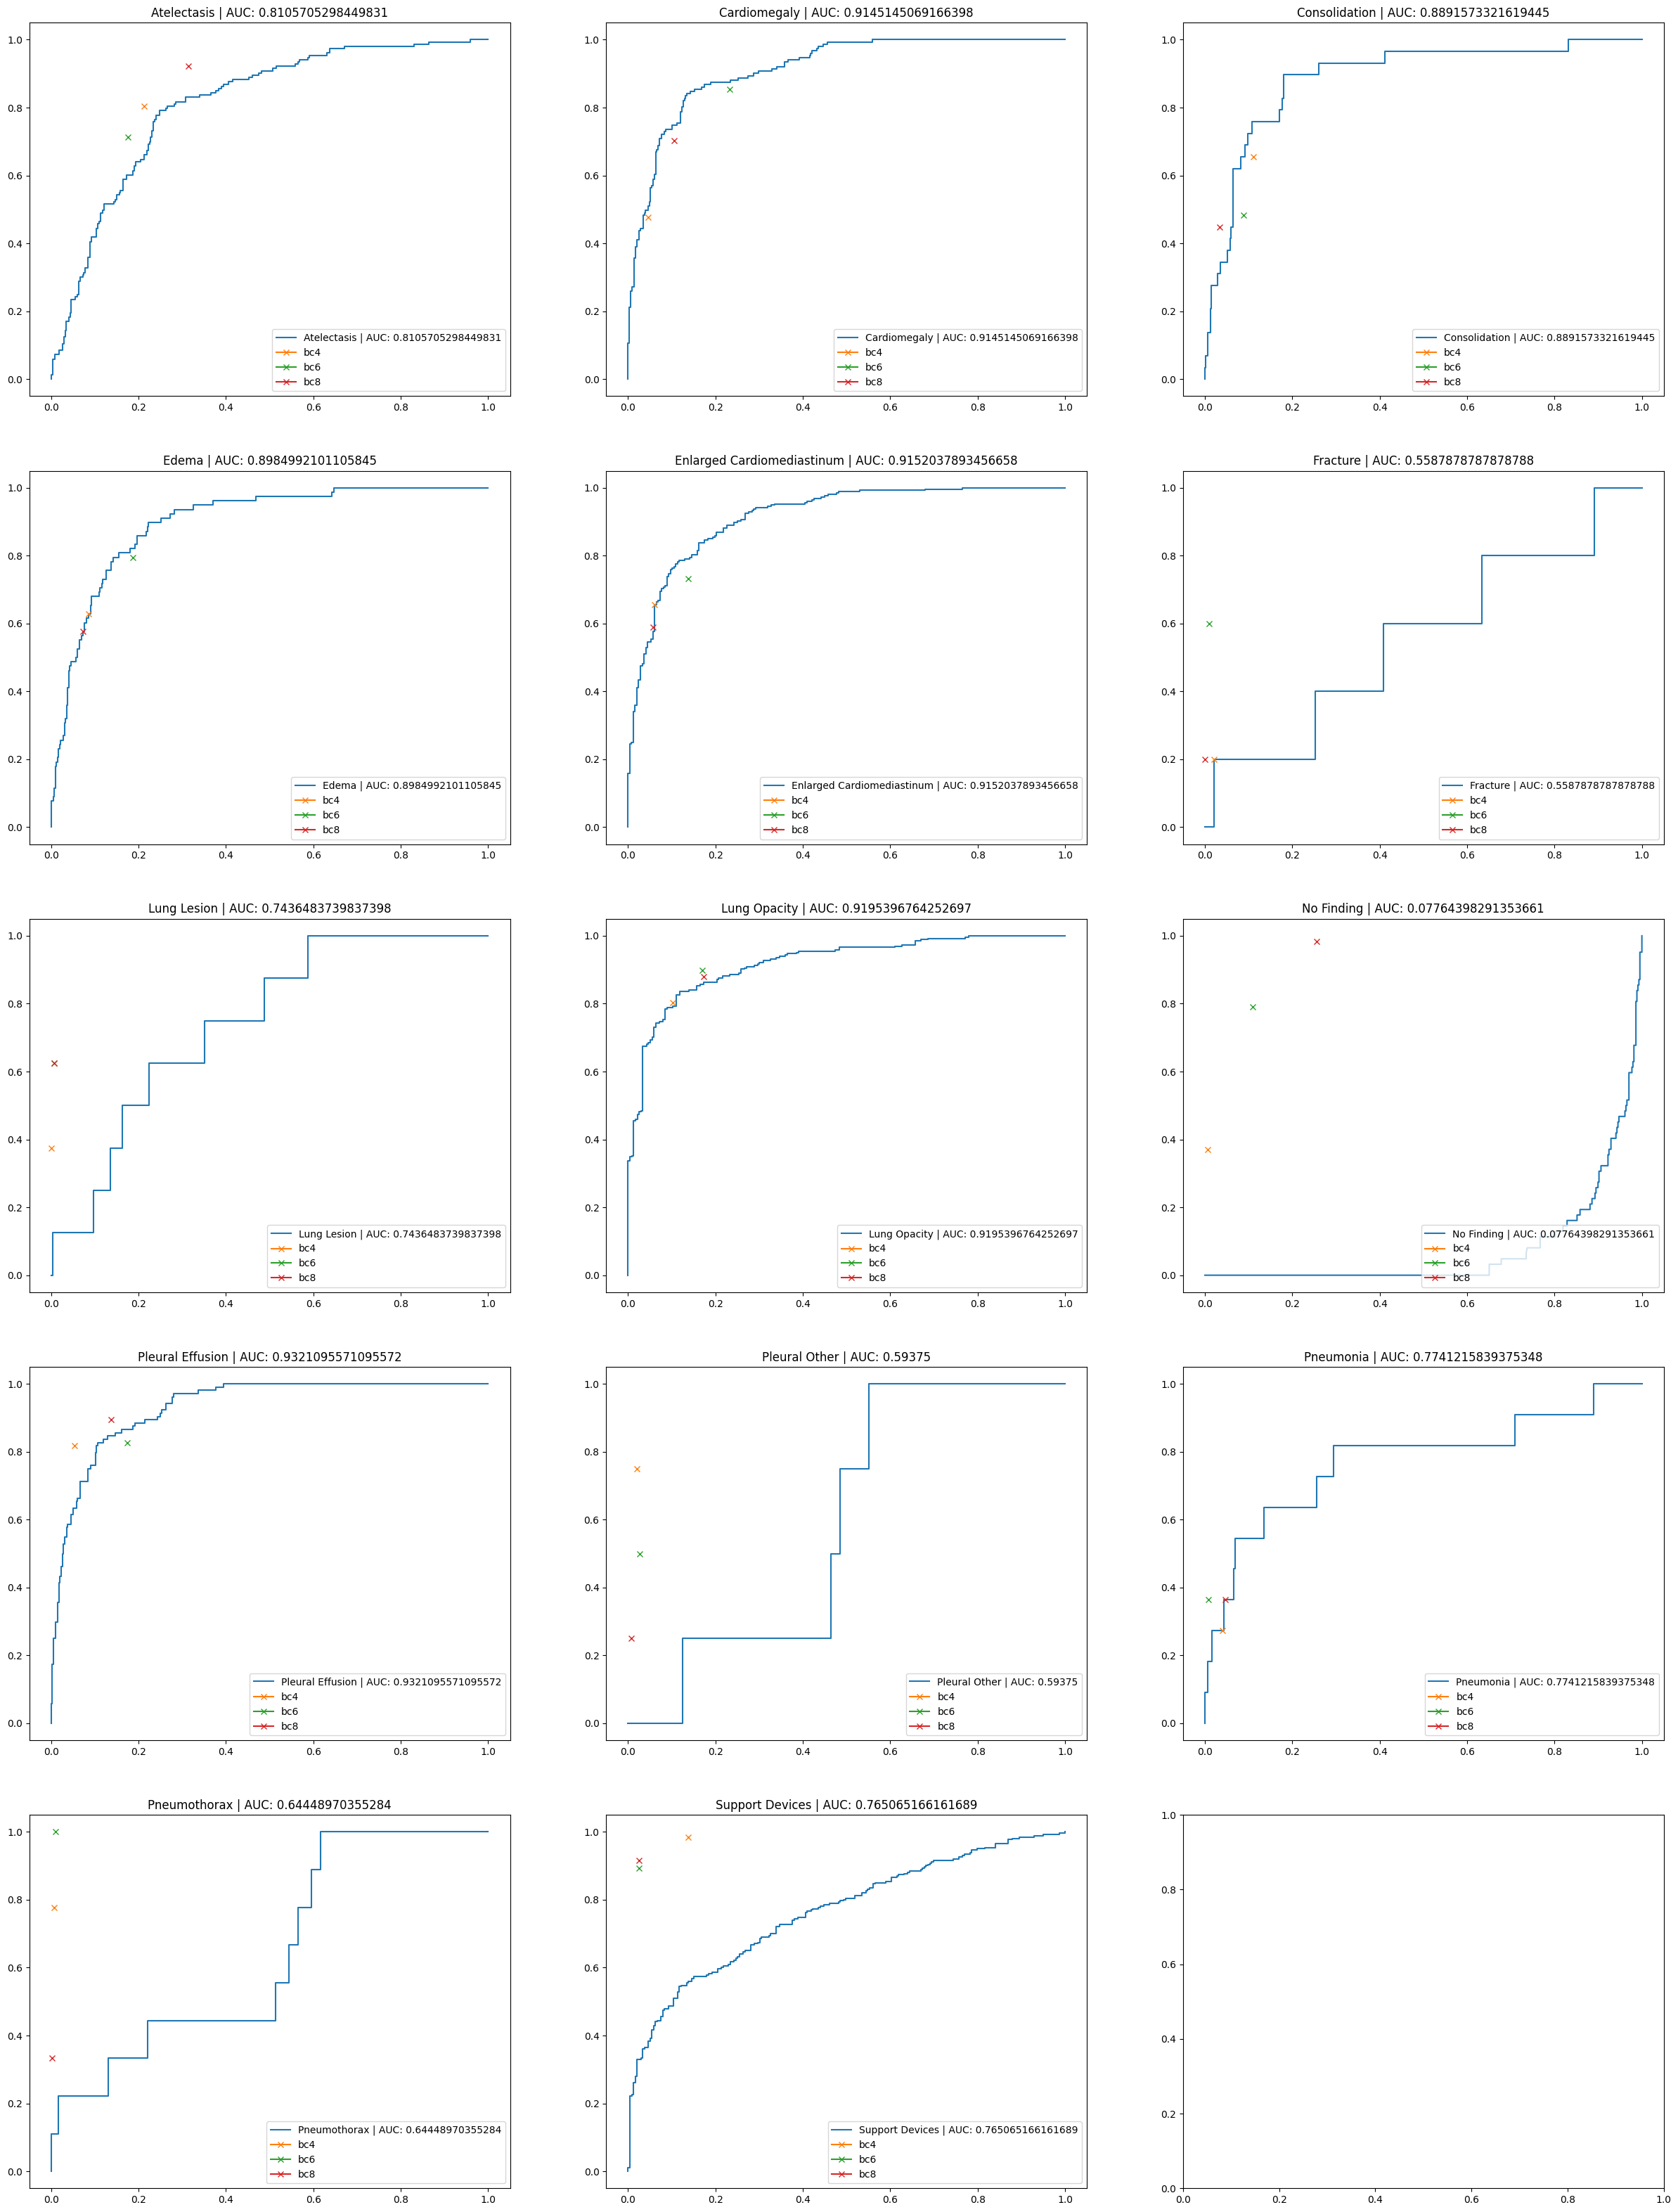

In [7]:
# plot results with benchmark radiologists

benchmarks = {}
benchmark_names = ['bc4', 'bc6', 'bc8']
benchmark_paths = [f'../data/{bname}.csv' for bname in benchmark_names]
groundtruth = pd.read_csv('../data/groundtruth.csv')
for bname, bpath in zip(benchmark_names, benchmark_paths):
    df_ = pd.read_csv(bpath)
    df_ = df_.set_index('Study').loc[groundtruth['Study']]    # align index
    df_ = df_[classnames]
    benchmarks[bname] = df_.values

ncol = 3
nrow = math.ceil(avg_pred.shape[-1]/ncol)
fig, axs = plt.subplots(nrow, ncol, figsize=(30, 40))

for i in range(nrow):
    for j in range (ncol):
        idx = i*ncol + j
        if idx >= avg_pred.shape[-1]:
            break
        fpr, tpr, _ = roc_curve(true[:, idx], avg_pred[:, idx])
        auc = roc_auc_score(true[:, idx], avg_pred[:, idx])
        axs[i, j].plot(fpr, tpr, label=f"{classnames[idx]} | AUC: {auc}")
        
        # plot benchmarks
        for bname, benchmark in benchmarks.items():
            fp = np.sum(np.logical_and(np.isclose(true[:, idx], 0), np.isclose(benchmark[:, idx], 1)))
            fpr = fp/(1-true[:, idx]).sum()
            tp = np.sum(true[:, idx] * benchmark[:, idx])
            tpr = tp/true[:, idx].sum()
            axs[i, j].plot(fpr, tpr, marker='x', label=bname)
        
        axs[i, j].legend(loc=4)
        axs[i, j].set_title(f"{classnames[idx]} | AUC: {auc}")
plt.show()

In [15]:
# results

best_thresholds, best_accuracies = optimize_accuracy(true, avg_pred)
df_results = pd.DataFrame(index=classnames)
df_results['best_threshold'] = best_thresholds
df_results['best_accuracy'] = best_accuracies

# best radiologist
b_arr = [make_true_labels(bpath, classnames) for bpath in benchmark_paths]
b_acc = [compute_column_metric(accuracy_score, true, b) for b in b_arr]
b_acc_best = np.array(b_acc).max(axis=0)
df_results['best_radiologist_acc'] = b_acc_best
b_acc_avg = np.array(b_acc).mean(axis=0)
df_results['avg_radiologist_acc'] = b_acc_avg


df_results['auc'] = aucs

df_results

,best_threshold,best_accuracy,best_radiologist_acc,avg_radiologist_acc,auc
Atelectasis,0.501458,0.768,0.792,0.780000,0.810571
Cardiomegaly,0.500539,0.862,0.836,0.813333,0.914515
Consolidation,0.509858,0.944,0.936,0.899333,0.889157
Edema,0.503677,0.882,0.872,0.850667,0.898499
Enlarged Cardiomediastinum,0.497305,0.838,0.796,0.785333,0.915204
Fracture,0.504212,0.988,0.992,0.983333,0.558788
Lung Lesion,0.508763,0.982,0.990,0.988667,0.743648
Lung Opacity,0.501979,0.858,0.866,0.856000,0.919540
No Finding,0.503244,0.874,0.916,0.856000,0.077644
Pleural Effusion,0.504211,0.888,0.920,0.872000,0.932110
